In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotting_functions import colour_dict
from network_functions import *

In [2]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [3]:
save_fig=False

In [4]:
plt.rcParams.update({'font.size': 8})

# functions

In [5]:
def remove_subscript (string,type): 
    for s in ['_FDR','_top500','_bonf']:
        if s in string:
            if type=='trait':
                string = string.replace(s, '')
            if type=='cutoff':
                string=s[1:len(string)]
    if ((type=='cutoff') & (string=='')):
        string='other'
    return string

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [6]:
tissue_network=False

In [7]:
interactome_name='PCNet2.0'

In [8]:
if tissue_network==False:
    if (interactome_name=='PCNet2.0'):
        all_nodes=list(pd.read_csv('PCNET2.0_allNodes.tsv',header=None)[0])
    else:
        interactome=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
        all_nodes=list(interactome.nodes())

else:
    netdir='tissue_networks/intermediate/'
    tissue='global'
    interactome_name=f'hb_tissue_{tissue}_top'
    #import node list
    with open(f'{netdir}node_list_{tissue}_top.txt', 'r') as file:
        lines = file.readlines()
    # Remove newline characters from each line
    all_nodes=[line.strip() for line in lines]

# import seed genes

In [9]:
if not tissue_network:
    seed_dict=import_seed_dict(mag_dir,file_dict,ctrl_traits,ctrl_traits_rat,bonf_dict,gene_col_dict,all_nodes)
else:
    hgnc=pd.read_csv('hgnc_complete_set.txt',sep='\t',low_memory=False)
    hgnc=hgnc[['symbol','entrez_id']].dropna()
    hgnc['entrez_id']=hgnc['entrez_id'].astype(int).astype(str)
    seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,hgnc[hgnc.entrez_id.isin(all_nodes)]['symbol']) 
seed_dict.keys()

dict_keys(['loco_bonf', 'loco_top500', 'loco_FDR', 'loco_gsem_bonf', 'loco_gsem_top500', 'loco_gsem_FDR', 'ext_bonf', 'ext_top500', 'ext_FDR', 'ext_st22', 'loco_mega_fus_naac_bonf', 'loco_mega_fus_naac_top500', 'loco_mega_fus_naac_FDR', 'ext_fus_naac_bonf', 'ext_fus_naac_top500', 'ext_fus_naac_FDR', 'loco_final_cf_bonf', 'loco_final_cf_top500', 'loco_final_cf_FDR', 'loco_final_mega_bonf', 'loco_final_mega_top500', 'loco_final_mega_FDR', 'ext_rat_bonf', 'ext_rat_top500', 'ext_rat_FDR', 'loco_final_cf_rat_bonf', 'loco_final_cf_rat_top500', 'loco_final_cf_rat_FDR', 'ext_db_bonf', 'ext_db_top500', 'ext_db_FDR', 'ext_rtb_bonf', 'ext_rtb_top500', 'ext_rtb_FDR', 'loco_final_cf_25_bonf', 'loco_final_cf_25_top500', 'loco_final_cf_25_FDR', 'facial_hair_FDR', 'facial_hair_bonf', 'facial_hair_top500', 'age_smkinit_FDR', 'age_smkinit_bonf', 'age_smkinit_top500', 'antisoc_FDR', 'antisoc_bonf', 'antisoc_top500', 'hr_FDR', 'hr_bonf', 'hr_top500', 'infant_bw_FDR', 'infant_bw_bonf', 'infant_bw_top500', 

In [10]:
seed_n={}
for k in seed_dict.keys():
    seed_n[k]=len(list(seed_dict[k]))
seed_count=pd.DataFrame.from_dict(seed_n,orient='index')
seed_count.columns=['n_seed']

# import all datasets as a table

In [11]:
files=os.listdir('colocalization_scores')
files.remove('.ipynb_checkpoints')

In [12]:
files=[x for x in files if interactome_name in x]
files=[x for x in files if ~('munged' in x)]

In [53]:
tbl=pd.DataFrame()
for f in files:
    print(f)
    t=pd.read_csv(f'colocalization_scores/{f}',sep='\t')
    tbl=pd.concat([tbl,t],axis=0,ignore_index=True)
    print(len(tbl))

colocScore_loco_final_cf_bonf_infant_bw_bonf_PCNet2.0.tsv
60
colocScore_loco_final_cf_bonf_body_length_rn6_bonf_PCNet2.0.tsv
120
colocScore_body_length_rn6_bonf_ext_FDR_PCNet2.0.tsv
180
colocScore_loco_final_cf_25_bonf_ext_fus_naac_top500_PCNet2.0.tsv
240
colocScore_loco_final_cf_25_bonf_maternal_smok_bonf_PCNet2.0.tsv
300
colocScore_loco_final_cf_FDR_facial_hair_top500_PCNet2.0.tsv
360
colocScore_bmi_rn6_bonf_addict-rf_FDR_PCNet2.0.tsv
420
colocScore_loco_final_cf_bonf_dpw_bonf_PCNet2.0.tsv
480
colocScore_loco_final_mega_top500_friend_sat_FDR_PCNet2.0.tsv
540
colocScore_loco_final_cf_25_bonf_antisoc_bonf_PCNet2.0.tsv
600
colocScore_loco_gsem_FDR_addict-rf_FDR_PCNet2.0.tsv
660
colocScore_loco_final_cf_FDR_nsex_bonf_PCNet2.0.tsv
720
colocScore_loco_FDR_LDL_top500_PCNet2.0.tsv
780
colocScore_loco_gsem_FDR_age_menarche_FDR_PCNet2.0.tsv
840
colocScore_loco_final_cf_top500_townsend_bonf_PCNet2.0.tsv
900
colocScore_bmi_rn6_bonf_bmi_bonf_PCNet2.0.tsv
960
colocScore_loco_final_cf_FDR_facial_ha

In [54]:
tbl['rat_trait']=tbl['rat_dataset'].apply(remove_subscript,type='trait')
tbl['rat_cutoff']=tbl['rat_dataset'].apply(remove_subscript,type='cutoff')
tbl['human_trait']=tbl['human_dataset'].apply(remove_subscript,type='trait')
tbl['human_cutoff']=tbl['human_dataset'].apply(remove_subscript,type='cutoff')

In [55]:
tbl=tbl[(~tbl['rat_dataset'].str.contains('fus'))& (~tbl['human_dataset'].str.contains('fus'))]
tbl=tbl[(~tbl['rat_dataset'].str.contains('rat'))& (~tbl['human_dataset'].str.contains('rat'))]
tbl=tbl[(~tbl['human_dataset'].str.contains('loco'))]

In [56]:
tbl=tbl.dropna(axis=0)

In [57]:
tbl['lower_error'] = tbl.apply(lambda x: x['obs_exp'] - x['observed_overlap']/(x['expected_overlap_mean']+ 1.96*x['expected_overlap_std']), axis = 1)
tbl['upper_error'] = tbl.apply(lambda x: x['observed_overlap']/(x['expected_overlap_mean'] - 1.96*x['expected_overlap_std']) - x['obs_exp'], axis = 1)

In [58]:
tbl=tbl.merge(seed_count, left_on='human_dataset',right_on=seed_count.index)

In [52]:
tback=tbl

# import meta data on traits

In [59]:
meta_data=pd.read_csv('gwas_ctrl_hm/ext1_st8_corr_sources_downloaded.csv')

In [60]:
meta_data['ctrl_type'][20]='positive'

/tmp/ipykernel_415567/792440445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_data['ctrl_type'][20]='positive'


In [61]:
meta_data['N trait 2']=meta_data['N trait 2'].apply(lambda x: int(x.replace(',','')))

In [62]:
meta_data

,Trait 1,Trait 2,N trait 2,rG,abs(rG),SE,Z,P value,Source,Domain,Subdomain,Phenotype,N,Prepared?,paper,Download,label,ctrl_type
0,Externalizing,Townsend deprivation index*,112151,0.707,0.707,0.047,15.167,5.820000e-52,CCACE,Socioeconomic,Economic & Environmental,Neighborhood deprivation (Townsend Index),112151,YES,NaN,http://www.psy.ed.ac.uk/ccace/downloads/Hill_C...,townsend,positive
1,Externalizing,Antisocial behavior,16400,0.647,0.647,0.166,3.906,9.400000e-05,CTG Lab,Psychopathology,Psychiatric Symptoms,Antisocial behavior,16400,YES,NaN,http://broadabc.ctglab.nl/documents/p12/BroadA...,antisoc,positive
2,Externalizing,Age of smoking initiation*,262990,-0.646,0.646,0.026,-24.708,8.760000e-135,GSCAN,Psychopathology,Substance Use,Age of smoking initiation,262990,YES,NaN,https://conservancy.umn.edu/handle/11299/201564,age_smkinit,positive
3,Externalizing,Friendships satisfaction*,361194,-0.001,0.001,0.032,-0.039,9.680000e-01,GWAS Atlas,Socioeconomic,Social,Friendships satisfaction,127735,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.4570.0...,friend_sat,negative
4,Externalizing,Infant birth weight*,361194,-0.012,0.012,0.020,-0.609,5.420000e-01,GWAS Atlas,Health & Medicine,Anthropomorphic,Infant birth weight,219088,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.20022....,infant_bw,negative
5,Externalizing,Heart rate*,361194,-0.026,0.026,0.018,-1.426,1.540000e-01,GWAS Atlas,Health & Medicine,Cardiometabolic,Heart rate,361411,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.102.0....,hr,negative
6,Externalizing,Age at first facial hair (male)*,167020,0.033,0.033,0.024,1.420,1.560000e-01,GWAS Atlas,Demography,Life History & Reproduction,Relative age of first facial hair (male),171805,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.2375.0...,facial_hair,negative
7,Externalizing,Maternal smoking around birth*,361194,0.717,0.717,0.021,34.403,2.240000e-259,GWAS Atlas,Socioeconomic,Economic & Environmental,Maternal smoking around birth,331862,YES,NaN,https://atlas.ctglab.nl/ukb2_sumstats/f.1787.0...,maternal_smok,positive
8,Externalizing,Age at menarche*,194174,-0.010,0.010,0.021,-0.461,6.450000e-01,ReproGen,Demography,Life History & Reproduction,Age at menarche,252514,YES,NaN,http://www.reprogen.org/Menarche_1KG_NatGen201...,age_menarche,negative
9,Externalizing,LDL,173081,0.025,0.025,0.032,0.768,4.430000e-01,GLGC,Health & Medicine,Cardiometabolic,LDL Cholesterol,188577,YES,NaN,http://csg.sph.umich.edu/abecasis/public/lipid...,LDL,negative


In [63]:
meta_sub=meta_data[['label','ctrl_type','N trait 2','rG']].sort_values('N trait 2')

In [64]:
rm=['antisoc', 'townsend', 'friend_sat', 'neurot','age_smkinit','bmi','height']

In [65]:
meta_sub=meta_sub[~meta_sub.label.isin(rm)]

In [66]:
meta_sub=meta_sub[meta_sub['N trait 2']>1.5e5]

# merge in meta data

In [67]:
tbl=tbl.merge(meta_sub,left_on='human_trait',right_on='label',how='right')
tbl['ctrl_type']=tbl['ctrl_type'].fillna('ext')

In [68]:
set(tbl.ctrl_type)

{'ext', 'ext-comp', 'negative', 'positive'}

In [69]:
tbl['colour']='white'
for i in tbl.index:
    if tbl.ctrl_type[i]=='ext':
        tbl['colour'][i]=colour_dict['shared']
    if tbl.ctrl_type[i]=='ext-comp':
        tbl['colour'][i]=colour_dict['shared_alt']        
    elif tbl.ctrl_type[i]=='negative':
        tbl['colour'][i]=colour_dict['other']
    elif tbl.ctrl_type[i]=='positive':
        tbl['colour'][i]='white'

/tmp/ipykernel_415567/3257276018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl['colour'][i]=colour_dict['other']
/tmp/ipykernel_415567/3257276018.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl['colour'][i]='white'
/tmp/ipykernel_415567/3257276018.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl['colour'][i]=colour_dict['shared_alt']
/tmp/ipykernel_415567/3257276018.py:4: SettingWithCopyWarning: 
A value is tr

# subset table for traits of interest

In [70]:
cut_comb=3
cut_single=1.5
t=['body_length_rn6_FDR','bmi_rn6_FDR','loco_final_cf_FDR']
rat_data=t[2]

In [71]:
tbl_sub=tbl[(tbl['z_comb']==cut_comb)&(tbl['z_12']==cut_single)
&(tbl['rat_dataset']==(rat_data))
&(~tbl['obs_exp'].isna())]

In [72]:
len_t=len(tbl_sub)

In [73]:
tbl_sub['sig_overlap']=tbl_sub['empirical_p']<(0.05/len_t)

/tmp/ipykernel_415567/4222877181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tbl_sub['sig_overlap']=tbl_sub['empirical_p']<(0.05/len_t)


In [74]:
tbl_sub=tbl_sub.sort_values('label',ascending=True)
tbl_sub=tbl_sub.sort_values('ctrl_type',ascending=True).reset_index().drop('index',axis=1)

In [75]:
trait_cut=[]
for f in set(tbl_sub.human_trait):
    if f=='ext_st22':
        g=f
    else:
        if (100<seed_n[f'{f}_bonf']<500):
            g=f'{f}_bonf'
        elif(100<seed_n[f'{f}_FDR']<500):
            g=f'{f}_FDR'
        else:
            g=f'{f}_top500'
    trait_cut.append(g)

In [77]:
#tbl_sub=tbl_sub[tbl_sub['n_seed']>=100]

In [88]:
save_fig=True

In [97]:
rat_trait='loco_ext_cf_FDR'

In [102]:
tbl_sub['human_trait']=tbl_sub['human_trait'].str.replace('_',' ')

In [105]:
tbl_mini=tbl_sub[(tbl_sub['human_dataset'].isin(trait_cut))]
tbl_mini=tbl_mini.sort_values('label',ascending=True)
tbl_mini=tbl_mini.sort_values('ctrl_type',ascending=True).reset_index().drop('index',axis=1)

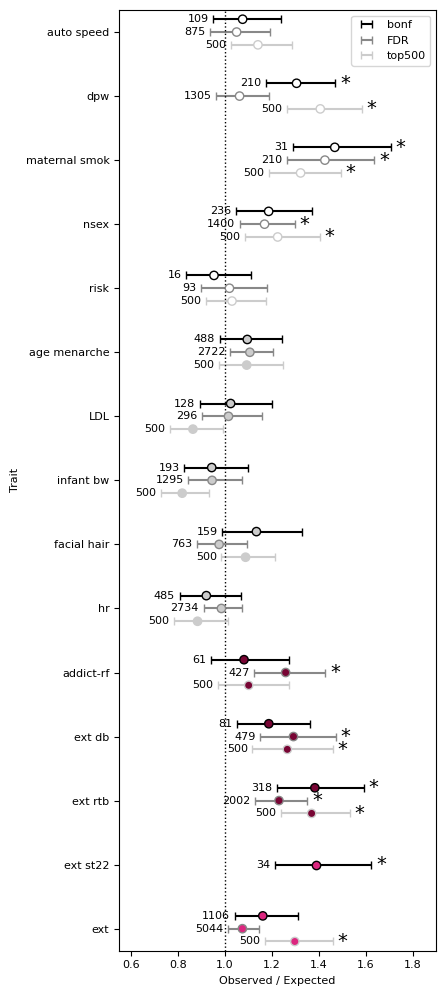

In [103]:
traits = tbl_sub['human_trait'].unique()
trait_to_y = {trait: i for i, trait in enumerate(traits)}
tbl_sub['y_numeric'] = tbl_sub['human_trait'].map(trait_to_y)

#set offset
offsets = {
    'bonf': 0.2,
    'FDR': 0.0,
    'top500': -0.2,
    'ext_st22':0.0
}

# Colors for error bars
ecolors = {
    'bonf': '#000000',
    'FDR': '#888888',
    'top500': '#cccccc',
    'ext_st22': '#000000',

}

fig=plt.figure(figsize=(4.5,10))
plt.margins(0.01)

for hcut, offset in offsets.items():
    filt = (tbl_sub['human_cutoff'] == hcut) & (tbl_sub['rat_cutoff'] == 'FDR')
    x = tbl_sub.loc[filt, 'obs_exp']
    y = tbl_sub.loc[filt, 'y_numeric'] + offset
    lower = tbl_sub.loc[filt, 'lower_error']
    upper = tbl_sub.loc[filt, 'upper_error']
    colors = tbl_sub.loc[filt, 'colour']
    if hcut=='ext_st22':
        plt.errorbar(
            x=x,
            y=y,
            xerr=[lower, upper],
            fmt='o',
            markersize=0,
            ecolor=ecolors[hcut],
            capsize=3,
            label=None
        )
    else:
        plt.errorbar(
        x=x,
        y=y,
        xerr=[lower, upper],
        fmt='o',
        markersize=0,
        ecolor=ecolors[hcut],
        capsize=3,
        label=hcut
    )
    plt.scatter(
        x=x,
        y=y,
        c=colors,
        edgecolors=ecolors[hcut],
        zorder=3
    
    )
    sigs = tbl_sub.loc[filt & tbl_sub['sig_overlap'], :]
    for xi, ui, yi in zip(sigs['obs_exp'], 
        sigs['upper_error'], 
        sigs['y_numeric'] + offset):
        plt.text(xi + ui + 0.02, yi, '*', fontsize=14, va='center', ha='left', color='black')

    # Add n_seed labels to the left of the lower error bar
    for xi, li, yi, label in zip(
        tbl_sub.loc[filt, 'obs_exp'],
        tbl_sub.loc[filt, 'lower_error'],
        tbl_sub.loc[filt, 'y_numeric'] + offset,
        tbl_sub.loc[filt, 'n_seed']):
        plt.text(xi - li - 0.02, yi, int(label), fontsize=8,
                 va='center', ha='right', color='black')


plt.axvline(x=1, color='black', linestyle=':', linewidth=1)

# Replace y-axis with trait names
plt.xlim(0.55,1.9)
plt.yticks(list(trait_to_y.values()), list(trait_to_y.keys()))
plt.xlabel('Observed / Expected')
plt.ylabel('Trait')
plt.legend()
plt.tight_layout()
if save_fig:
    plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_trait}_{cut_single}_{cut_comb}.svg')

In [94]:
list(trait_to_y.keys())

['ext',
 'ext_st22',
 'ext_rtb',
 'ext_db',
 'addict-rf',
 'hr',
 'facial_hair',
 'infant_bw',
 'LDL',
 'age_menarche',
 'risk',
 'nsex',
 'maternal_smok',
 'dpw',
 'auto_speed']

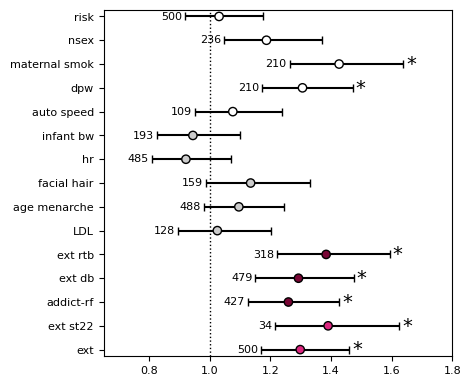

In [106]:
fig=plt.figure(figsize=(4.5,4.5))
plt.margins(0.02)
plt.errorbar(
        x=tbl_mini.obs_exp,
        y=tbl_mini.human_trait,
        xerr=[tbl_mini.lower_error, tbl_mini.upper_error],
        fmt='o',
        markersize=0,
        ecolor=ecolors[hcut],
        capsize=3,
        label=tbl_mini.human_trait)
plt.scatter(
    x=tbl_mini.obs_exp,
    y=tbl_mini.human_trait,
    c=tbl_mini.colour,
    edgecolors=ecolors[hcut],
    zorder=3)
sigs = tbl_mini.loc[ tbl_mini['sig_overlap'], :]
for xi, ui, yi in zip(
    sigs['obs_exp'], 
    sigs['upper_error']+0.01, 
    sigs['human_trait']):
    plt.text(xi + ui, yi, '*', fontsize=14, va='center', ha='left', color='black')


for xi, ui, yi,label in zip(
    tbl_mini['obs_exp'], 
    tbl_mini['lower_error'], 
    tbl_mini['human_trait'],
    tbl_mini['n_seed']):
    plt.text(xi - ui - 0.01, yi, int(label), fontsize=8, va='center', ha='right', color='black')

plt.axvline(x=1, color='black', linestyle=':', linewidth=1)
plt.xlim(0.65,1.8)
plt.savefig(f'figures/network_overlap_barplot_ctrls_{interactome_name}_{rat_trait}_{cut_single}_{cut_comb}_mini.svg')

In [82]:
subset='postive'
t=tbl_mini[tbl_mini.ctrl_type==subset]

(0.65, 1.8)

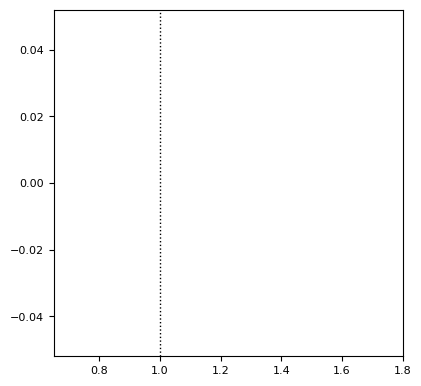

In [84]:
fig=plt.figure(figsize=(4.5,4.5))
plt.margins(0.02)
plt.errorbar(
        x=t.obs_exp,
        y=t.human_trait,
        xerr=[t.lower_error, t.upper_error],
        fmt='o',
        markersize=0,
        ecolor=ecolors[hcut],
        capsize=3,
        label=t.human_trait)
plt.scatter(
    x=t.obs_exp,
    y=t.human_trait,
    c=t.colour,
    edgecolors=ecolors[hcut],
    zorder=3)
sigs = t.loc[ t['sig_overlap'], :]
for xi, ui, yi in zip(
    sigs['obs_exp'], 
    sigs['upper_error']+0.01, 
    sigs['human_trait']):
    plt.text(xi + ui, yi, '*', fontsize=14, va='center', ha='left', color='black')


for xi, ui, yi,label in zip(
    t['obs_exp'], 
    t['lower_error'], 
    t['human_trait'],
    t['n_seed']):
    plt.text(xi - ui - 0.01, yi, int(label), fontsize=8, va='center', ha='right', color='black')


plt.axvline(x=1, color='black', linestyle=':', linewidth=1)
plt.xlim(0.65,1.8)


# older plotting functions

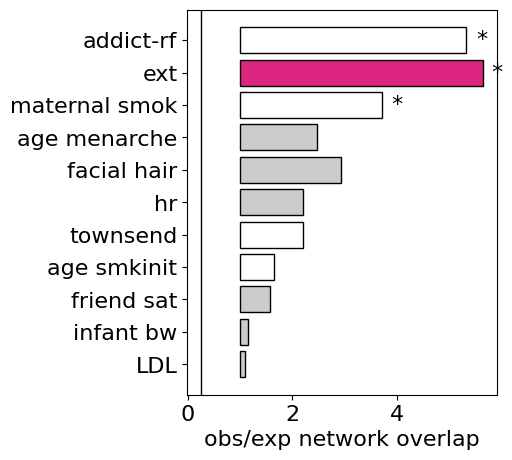

In [42]:
plt.figure(figsize=(4,5))

# Create horizontal bars
bars = plt.barh(y=tbl_sub.hm_label.map(lambda x: x.replace('_',' ')),
                left=1, width=-np.log10(tbl_sub.empirical_p), capsize=4, edgecolor="black",
                color=tbl_sub.colour)

# Set labels and title
plt.yticks(rotation=0)
plt.xlabel('obs/exp network overlap')
#plt.title(subset)
plt.axvline(x=-np.log10(0.05/len(tbl_sub)), color='black', linestyle='solid', linewidth=1)

# Find the maximum width to set a limit for star placement
max_width = max(tbl_sub.obs_exp - 1 + tbl_sub.upper_error)

# Add significance stars
for i, (bar, sig, upper_err) in enumerate(zip(bars, tbl_sub.sig_overlap, tbl_sub.upper_error)):
    if sig:  # if sig_overlap is True
        # Get the bar's width and position to place the star
        star_x_position = bar.get_width() + 1 + upper_err  # Add a small margin above the error bar
        plt.text(star_x_position, bar.get_y() + bar.get_height() / 2, '*',
                 ha='left', va='center', fontsize=16, color='black')

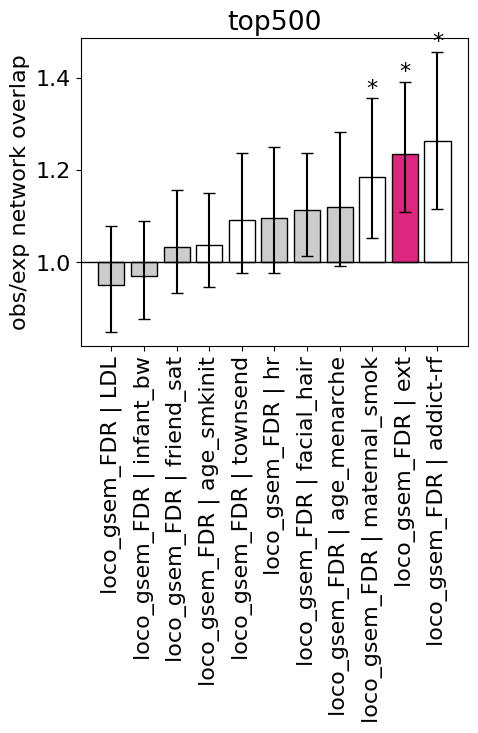

In [27]:

plt.figure(figsize=(5,4))
bars=plt.bar(x = tbl_sub.rat_dataset+' | '+tbl_sub.hm_label,
       bottom= 1, height = tbl_sub.obs_exp-1, capsize=4, edgecolor="black",
        yerr = [tbl_sub.lower_error, tbl_sub.upper_error],
        color =tbl_sub.colour)
plt.xticks(rotation = 90)
plt.ylabel('obs/exp network overlap')
plt.title(subset)
plt.axhline(y = 1, color = 'black', linestyle = 'solid', linewidth=1)
max_height = max(tbl_sub.obs_exp - 1 + tbl_sub.upper_error)

for i, (bar, sig, upper_err) in enumerate(zip(bars, tbl_sub.sig_overlap, tbl_sub.upper_error)):
    if sig:  # if sig_overlap is True
        # Get the bar's height and position to place the star
        # Place the star above the upper error bar
        star_y_position = bar.get_height() + 1 + upper_err  # Add a small margin above the error bar
        plt.text(bar.get_x() + bar.get_width() / 2, star_y_position, '*',
                 ha='center', va='bottom', fontsize=16, color='black')

#plt.ylim(max_height + 0.2)  # Add 20% margin above the tallest bar

if save_fig:
    plt.savefig('../figures/barplot_network_overlap.svg',bbox_inches='tight')

## heatmap- use for tissue specific networks

In [296]:
t = tbl_sub.pivot(index='human_dataset', columns='rat_dataset', values='obs_exp')
distance = t.applymap(lambda x: (x - 1))
annot_data = tbl_sub.pivot(index='human_dataset', columns='rat_dataset', values='empirical_p')
annot = annot_data.applymap(lambda p: '*' if p < 0.05/len(tbl_sub) else '')


KeyboardInterrupt: 

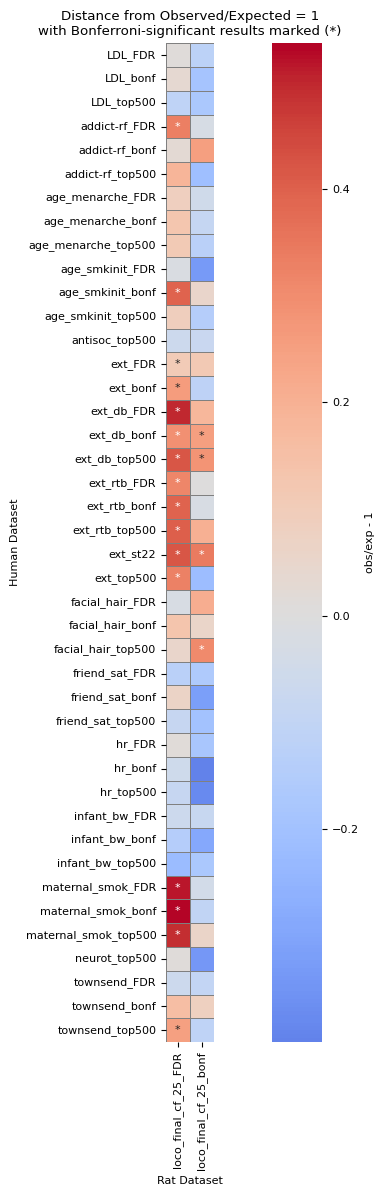

In [113]:
plt.figure(figsize=(12,12))
sns.heatmap(distance, annot=annot, fmt='', cmap='coolwarm', center=0,
            cbar_kws={'label': 'obs/exp - 1'}, linewidths=0.5, linecolor='gray',square=True)

plt.title('Distance from Observed/Expected = 1\nwith Bonferroni-significant results marked (*)')
plt.ylabel('Human Dataset')
plt.xlabel('Rat Dataset')
plt.tight_layout()
plt.show()

# fix erroneous labels - only run if needed